In [30]:
# general purpose libraries
import os
import shutil
from shutil import copyfile
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# for data loading and data transformation images
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# create neural network structure
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [83]:
IMAGE_DIR = "drive/My Drive/ml/MangaColorizer/images"
LOCAL_IMAGE_DIR = "image_17"
IMAGE_CSV = ""

In [104]:
class MangaDataset(Dataset):
  """Manga Dataset"""

  def __init__(self, csv_file, root_dir):
    self.image_names = pd.read_csv(csv_file, index_col=0)
    self.root_dir = root_dir
    
    self.transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

  def __len__(self):
    return len(self.image_names)
  
  def __getitem__(self, idx):
    img_name = os.path.join(self.root_dir, self.image_names.iloc[idx, 0])
    
    # apply transformations
    pil_img = Image.open(img_name)
    transformed_pil_img = self.transform(pil_img)

    return transformed_pil_img

In [90]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [105]:
manga_dataset = MangaDataset(csv_file="images17.csv", root_dir=LOCAL_IMAGE_DIR)

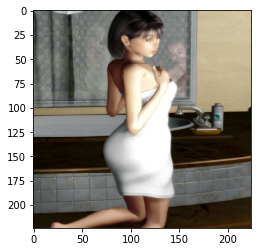

In [110]:
imshow(manga_dataset[0])

In [111]:
class LowLevelFeatureNetwork(nn.Module):
      def __init__(self):
        super(MangaNet, self).__init__()
        # monochrome manga page only has a single channel so we start at 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

Function to create a csv of the image names

In [0]:
def create_csv(image_dir, image_csv_name):
  """
  Function to create a csv from the directory of images.

  Parameters:
    image_dir: Directory where all the images are located.
    image_csv_name: Name of the csv you want to output to.
  """
  # create a dict with all csv names
  counter = 0
  image_dict = {}
  for image in images:
    image_dict[counter] = [images]
    counter += 1

  # create a pandas df from the dict
  image_df = pd.DataFrame.from_dict(image_dict, columns=["image_name"], orient="index")

  # convert the pandas df to csv
  image_df.to_csv(image_csv_name)

Function to copy images from each file into a single file

In [0]:
def copy_into_single_file(source_list, dest):
  """
  Copies images present in multiple files into a single file.

  Parameters:
    source_list: List of source files to copy from.
    dest: The file you want to copy the images into.
  """
  for files in source_list:
    if "dataset" in files:
      for images in os.listdir(files):
        copyfile(files + "/" + images, dest + "/" + images)